In [1]:
import pickle
import os.path
import numpy as np
import pandas as pd
import umap
import plotly.graph_objs as go
from sqlalchemy import create_engine
import hdbscan
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from spacy.lang.en import English

In [2]:
path = os.getcwd()
path.split()
with open('./data/SQL_access.pkl', 'rb') as file:
    PASSWORD = pickle.load(file)
engine = create_engine('postgresql://postgres:' + PASSWORD +
                        '@dsj-1.c9mo6xd9bf9d.us-west-2.rds.amazonaws.com:5432/')
df = pd.read_sql("select * from all_data where language like'en'", engine)
print('Loaded data from SQL database...\n')
df = df.dropna(subset=['region', 'country', 'description', 'job_title'], axis=0)
df = df.loc[df.salary_type =='yearly']

Loaded data from SQL database...



In [3]:
df['full_description'] = df['job_title']+ ' ' + df['description']

In [4]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Lower case of all words
    2. Remove all punctuation
    3. Remove all stopwords
    4. Returns a list of the cleaned text
    """
    punctuations = '!"$%&\'()*,-./:;<=>?@[\\]^_`{|}~'

    # transforms all to lower case words
    mess = mess.lower()

    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in punctuations]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)

    # Now just remove any stopwords
    return [word for word in nopunc.split() if word not in spacy.lang.en.stop_words.STOP_WORDS]

def spacy_tokenizer(doc):
    """
    Tokenizing and lemmatizing the document using SpaCy
    :param doc: text
    :return:
    """
    spacy.load('en_core_web_lg')
    lemmatizer = spacy.lang.en.English()
    tokens = lemmatizer(doc)
    return [token.lemma_ for token in tokens]

In [5]:
TFIDF = TfidfVectorizer(analyzer=text_process, use_idf=True, tokenizer=spacy_tokenizer, min_df=3)
TFIDF_fit = TFIDF.fit(df['full_description'])
TFIDF_transform = TFIDF_fit.transform(df['full_description'])
print('Trained TF-IDF model...\n')

Trained TF-IDF model...



In [6]:
standard_embedding = umap.UMAP(n_neighbors=20, min_dist=0.0, n_components=2, random_state=42).fit_transform(TFIDF_transform)

/Users/jamoth/anaconda3/envs/dsj/lib/python3.7/site-packages/umap/sparse.py:247: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/dsj/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^


/Users/jamoth/anaconda3/envs/dsj/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/dsj/lib/python3.7/site-packages/umap/spar

In [140]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=1)
cluster_labels = clusterer.fit_predict(standard_embedding[:,0:2])

In [141]:
cluster_labels

array([16, 16, 16, ...,  8,  5,  3])

In [142]:
np.unique(cluster_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18])

In [143]:
from collections import defaultdict

In [151]:
rf = pd.DataFrame({'x': [x for x in standard_embedding[:, 0]],
                    'y': [y for y in standard_embedding[:, 1]],
                    'label': [x for x in cluster_labels],
                      'company':df['company'],
                      'region':df['region'],
                      'title':df['job_title']})

def create_trace(rf, clusters):
    data = []
    for idx, cluster in enumerate(clusters):
        df = rf.loc[rf['label'] == cluster]
        if cluster == -1:
            data.append(dict(type='scatter', x=df.x, y=df.y, mode = 'markers', marker=dict(color='lightgrey'), text=df['title'], name = str(cluster)))
        else:
            data.append(dict(type='scatter', x=df.x, y=df.y, mode = 'markers', marker={"color": cluster, "cmid": 0}, text=df['title'], name = str(cluster)))
    return data  

In [152]:
data = create_trace(rf, np.unique(cluster_labels))

In [153]:
len(data)

20

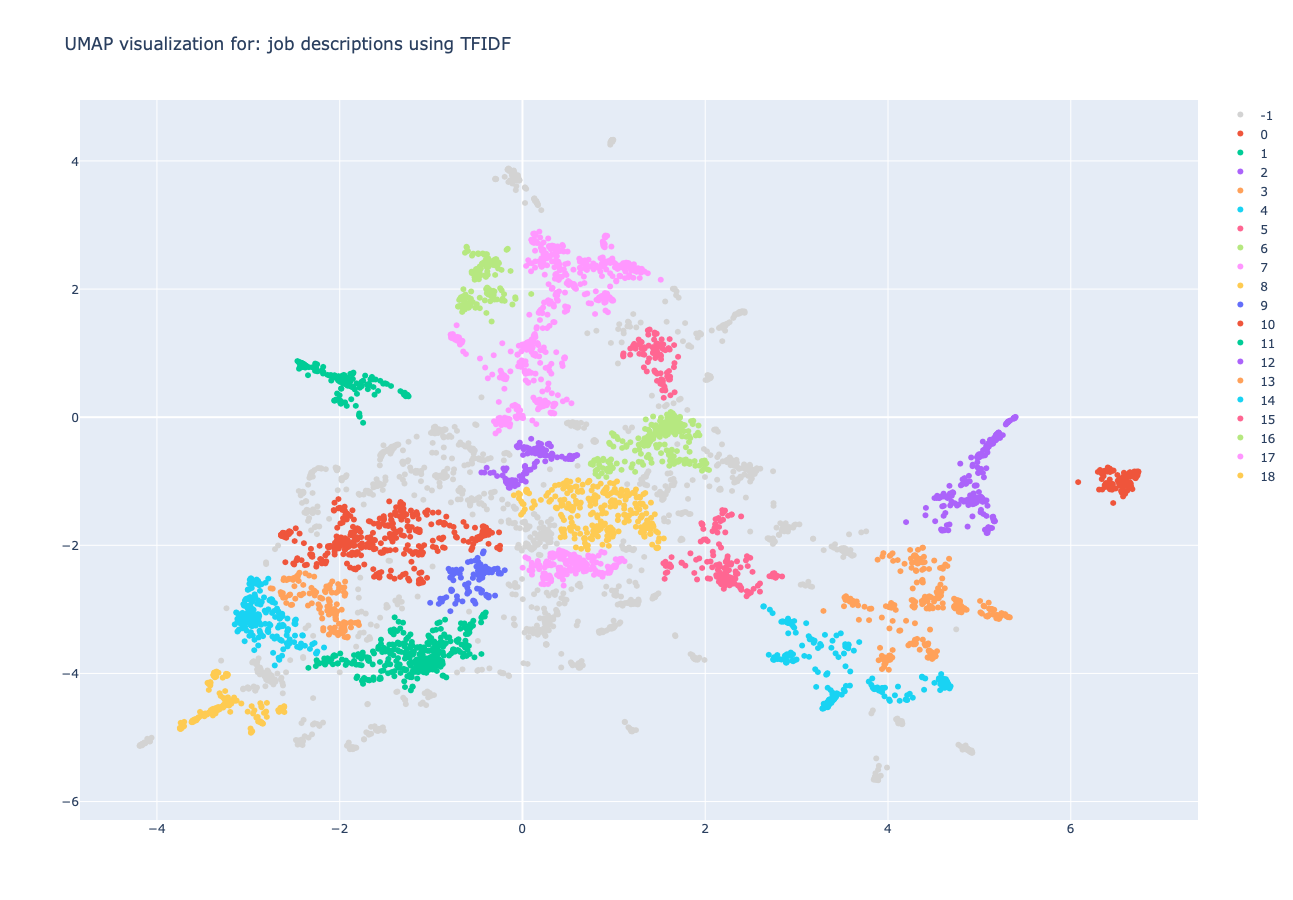

In [154]:
fig = go.Figure(data=data, layout=layout) 
fig.update_traces(textposition='top center')

fig.show(config=dict(displaylogo=False,editable=True))

In [155]:
fig.write_html(file='cluster_job.html', include_plotlyjs=False, full_html=False)
fig.write_html(file='cluster_job_alone.html', include_plotlyjs='cdn')